# w261 Final Project - Clickthrough Rate Prediction


[Your team number (from the spreadsheet)]   
[Your team names]   
Summer 2019, section [Your section numbers>]   

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

# __Section 2__ - Algorithm Explanation

# __Section 3__ - EDA & Challenges

# __Section 4__ - Algorithm Implementation

# __Section 5__ - Course Concepts

### Setup and Initiate Spark

In [188]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import Imputer
import math
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session (RUN THIS CELL AS IS)
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [5]:
# Spark configuration Information (RUN THIS CELL AS IS)
sc.getConf().getAll()

[('spark.driver.port', '39433'),
 ('spark.app.id', 'local-1564879088366'),
 ('spark.app.name', 'hw3_notebook'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'docker.w261')]

### Setup Path and read in raw data files

In [6]:
raw_test = PWD + '/data/test.txt'
raw_train = PWD + '/data/train.txt'

In [7]:
rawTestRDD = sc.textFile(raw_test)
rawTrainRDD = sc.textFile(raw_train)

### Check Row Counts

In [8]:
rawTestRDD.count()

6042135

In [9]:
rawTrainRDD.count()

45840617

### Split Training data into Train, Dev, Test subsets and Create Toy

In [8]:
rtrainRDD, rdevRDD, rtestRDD = rawTrainRDD.randomSplit([0.8,0.1, 0.1], seed = 2018)

In [57]:
#DO NOT RUN THIS CELL AGAIN
#Writing Toy sample to file for easy access
rtoy = rtrainRDD.takeSample(False, 100)

with open("toy.txt", "w") as file:
    file.write(str(rtoy))

### Parse Row Into Readable formats and running some tests

In [9]:
def parse_raw_row(row):
    '''
    for each row in the raw data,  outputs the following tuple:
        - (label, features_vector)
        where features_vector is comma separated string of features
        features with no value are replaced by empty string ''
    '''
    row_values = row.split('\t')
    new_values = [value if value != '' else "''" for value in row_values[1:]]
    output_string = ",".join(new_values)
    return (row_values[0], output_string)

In [10]:
#Retrieving toy sample by reading
rtoyRDD = ast.literal_eval(open("toy.txt", "r").read())

toyRDD = sc.parallelize(rtoyRDD).map(parse_raw_row).cache()

#test parsing on toy 
toyRDD.take(5)

[('0',
  "'',-1,'','',23106,90,8,32,103,'',2,'','',68fd1e64,d833535f,b00d1501,d16679b9,25c83c98,fe6b92e5,e30c82b2,51d76abe,a73ee510,7471f41c,9bd51b96,e0d76380,18539b7f,b28479f6,a733d362,1203a270,e5ba7672,281769c2,'','',73d06dde,'',3a171ecb,aee52b6f,'',''"),
 ('0',
  "'',17,4,1,11391,284,2,1,374,'',2,'',1,68fd1e64,38a947a1,'','',25c83c98,7e0ccccf,5ce4765a,0b153874,a73ee510,f0405fd0,c1dcf5cb,'',bccc0f27,07d13a8f,cfd71361,'',e5ba7672,8f6ce7c7,'','','',ad3062eb,32c7478e,'','',''"),
 ('1',
  "'',41,5,1,8674,14,1,2,14,'',1,'',1,05db9164,a07503cc,5300bdf3,13508380,25c83c98,fbad5c96,05940d6c,0b153874,a73ee510,3b08e48b,59256bd8,0f52da65,679527fa,07d13a8f,77660bba,cdf08556,d4bb7bd8,912c7e21,55dd3565,b1252a9d,47869145,'',32c7478e,45ab94c8,445bbe3b,c84c4aec"),
 ('1',
  "'',-1,'','',5762,1,1,0,0,'',1,'','',05db9164,2705da39,64e7c756,8bcf4b56,25c83c98,7e0ccccf,0dbf2675,0b153874,a73ee510,753998f6,88196a93,7b559283,1211c647,07d13a8f,74056b5a,6a473526,e5ba7672,66c3058a,'','',36697b7d,'',32c7478e,043ce5

In [11]:
#checking that toy sample contains click rates that match training data
toyRDD.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x+y).collect()

[('0', 75), ('1', 25)]

In [12]:
#parsing all data set

trainRDD = rtrainRDD.map(parse_raw_row).cache()
devRDD = rdevRDD.map(parse_raw_row).cache()
testRDD = rtestRDD.map(parse_raw_row).cache()

parsedTestRDD = rawTestRDD.map(parse_raw_row).cache()

# Logistic Regression with Gradient Descent

## Testing DF

In [178]:
toyDF = sc.parallelize(rtoyRDD).map(lambda x: x.split('\t')).toDF()

In [179]:
toyDF.show()

+---+---+----+---+---+------+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| _1| _2|  _3| _4| _5|    _6| _7| _8| _9|_10|_11|_12|_13|_14|     _15|     _16|     _17|     _18|     _19|     _20|     _21|     _22|     _23|     _24|     _25|     _26|     _27|     _28|     _29|     _30|     _31|     _32|     _33|     _34|     _35|     _36|     _37|     _38|     _39|     _40|
+---+---+----+---+---+------+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|   |  -1|   |   | 23106| 90|  8| 32|103|   |  2|   |   |68fd1e64|d833535f|b00d1501|d16679b9|25c83c98|fe6b92

In [180]:
#extract only numeric values and transform from str to int
toyDFNum = sc.parallelize(rtoyRDD)\
            .map(lambda x: x.split('\t'))\
            .map(lambda x: x[:14])\
            .map(lambda x: list(map(lambda y: float(y) if y!='' else None, x)))\
            .toDF()
toyDFNum.show()

+---+-----+------+----+----+--------+-----+-----+----+-----+----+----+----+----+
| _1|   _2|    _3|  _4|  _5|      _6|   _7|   _8|  _9|  _10| _11| _12| _13| _14|
+---+-----+------+----+----+--------+-----+-----+----+-----+----+----+----+----+
|0.0| null|  -1.0|null|null| 23106.0| 90.0|  8.0|32.0|103.0|null| 2.0|null|null|
|0.0| null|  17.0| 4.0| 1.0| 11391.0|284.0|  2.0| 1.0|374.0|null| 2.0|null| 1.0|
|1.0| null|  41.0| 5.0| 1.0|  8674.0| 14.0|  1.0| 2.0| 14.0|null| 1.0|null| 1.0|
|1.0| null|  -1.0|null|null|  5762.0|  1.0|  1.0| 0.0|  0.0|null| 1.0|null|null|
|1.0|  2.0|  19.0| 9.0|42.0|     4.0| 34.0|  2.0|49.0| 39.0| 1.0| 1.0|null|16.0|
|0.0| null|   1.0|20.0|36.0|  8998.0| null|  0.0|38.0| 47.0|null| 0.0|null|38.0|
|0.0|  0.0|   8.0| 1.0|null|  2111.0| 22.0| 91.0|20.0|344.0| 0.0|27.0| 1.0|null|
|0.0| null|   3.0| 5.0| 1.0| 87474.0| null|  0.0| 1.0|  1.0|null| 0.0|null| 1.0|
|1.0| null| 216.0| 8.0| 1.0| 13504.0|107.0|  7.0| 7.0| 44.0|null| 1.0|null| 1.0|
|0.0|  1.0|  25.0| 4.0| 0.0|

In [181]:
# use average imputer for null values

def imputeNumeric(numeric_DF):
    '''
    takes a spark df with continuous numeric columns
    outputs a spark df where all null values are replaced with the column average
    
    the first column, which is the outcome values, are preserved
    '''
    outputColumns=["{}_imputed".format(c) for c in numeric_DF.columns[1:]]
    
    imputer = Imputer(
        inputCols=numeric_DF.columns[1:], 
        outputCols=["{}_imputed".format(c) for c in numeric_DF.columns[1:]]
    )

    model = imputer.fit(numeric_DF)

    imputedDF = model.transform(numeric_DF).select(['_1']+outputColumns)

    return imputedDF

In [182]:
imputedToyDF = imputeNumeric(toyDFNum)
imputedToyDF.show()

+---+-----------------+----------+----------+----------------+----------+------------------+----------+----------+------------------+------------------+------------------+------------------+-----------------+
| _1|       _2_imputed|_3_imputed|_4_imputed|      _5_imputed|_6_imputed|        _7_imputed|_8_imputed|_9_imputed|       _10_imputed|       _11_imputed|       _12_imputed|       _13_imputed|      _14_imputed|
+---+-----------------+----------+----------+----------------+----------+------------------+----------+----------+------------------+------------------+------------------+------------------+-----------------+
|0.0|6.244897959183674|      -1.0|    16.375|8.30379746835443|   23106.0|              90.0|       8.0|      32.0|             103.0|0.6122448979591837|               2.0|0.5217391304347826|8.430379746835444|
|0.0|6.244897959183674|      17.0|       4.0|             1.0|   11391.0|             284.0|       2.0|       1.0|             374.0|0.6122448979591837|            

In [183]:
def scaleFeatures(imputedDF):
    '''
    inputs imputed data frame with no null values and continuous features
    transforms the data frame into 2 column data frame with first column as label and second column as dense vector of features
    scales all features using the StandardScalar
    returns 2 column dataframe with scaled features
    '''
    
    transformedImputedDF = imputedDF.rdd.map(lambda x: (x[0], Vectors.dense(x[1:]))).toDF(['label', 'x'])
    
    scaler = StandardScaler(inputCol="x", 
                        outputCol="features",
                        withStd=True, withMean=True)

    scalerModel = scaler.fit(transformedImputedDF)
    scaledDF = scalerModel.transform(transformedImputedDF).select(['label', 'features'])
    
    return scaledDF

In [184]:
#normalize
scaledToyDF = scaleFeatures(imputedToyDF)
scaledToyDF.show(2, False)

+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                               |
+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0.0  |[0.0,-0.3111729172762192,0.0,-1.7866088267741792E-16,-0.059208449719059045,-0.25040274650358685,-0.15931121113653807,1.3524026880502105,-0.023242706161846757,0.0,-0.018112398023369714,0.0,0.0]                       |
|0.0  |[0.0,-0.2706409503395961,-0.5317462824228277,-0.7345950282342292,-0.15462310942359733,0.933226885

# Homegrown Gradient Descent

In [303]:
def LRLoss_Standard(dataRDD, W):
    augmentedData = dataRDD.map(lambda x: (x[0], np.append([1.0], x[1]))).cache()
    
    loss = augmentedData.map(lambda x: math.log(1+math.exp(-x[0]*np.dot(W, x[1]))))\
                        .reduce(lambda x,y: x + y)
    return loss

def GDUpdate_Standard(dataRDD, W, learningRate = 0.1):
    
    augmentedData = dataRDD.map(lambda x: (x[0], np.append([1.0], x[1]))).cache()
    
    new_model = None
    
    grad = augmentedData.map(lambda x: -x[0]*(1-1/(1+math.exp(-x[0]*np.dot(W, x[1]))))*x[1])\
                            .reduce(lambda x,y: x + y)
    new_model = W-learningRate*grad
    
    return new_model

def LRLoss_Modified(dataRDD, W):
    augmentedData = dataRDD.map(lambda x: (x[0], np.append([1.0], x[1]))).cache()
    
    loss = augmentedData.map(lambda x: math.log(1+math.exp(-np.dot(W, x[1]))) - (1-x[0])*math.log(math.exp(-np.dot(W, x[1]))/(1+math.exp(-np.dot(W, x[1])))))\
                        .sum()
    return loss

def GDUpdate_Modified(dataRDD, W, learningRate = 0.1):
    augmentedData = dataRDD.map(lambda x: (x[0], np.append([1.0], x[1]))).cache()
    
    new_model = None
    
    grad = augmentedData.map(lambda x: x[0]*(1/(1+math.exp(-np.dot(W, x[1])))-1)*x[1])\
                            .reduce(lambda x,y: x + y)
    new_model = W-learningRate*grad
    
    return new_model

In [307]:
#turn scaledToyDF to rdd:

scaledToyRDD = scaledToyDF.rdd.map(lambda x: (2*x[0]-1, np.array(x[1])))
scaledToyRDD.take(5)

[(-1.0,
  array([ 0.00000000e+00, -3.11172917e-01,  0.00000000e+00, -1.78660883e-16,
         -5.92084497e-02, -2.50402747e-01, -1.59311211e-01,  1.35240269e+00,
         -2.32427062e-02,  0.00000000e+00, -1.81123980e-02,  0.00000000e+00,
          0.00000000e+00])),
 (-1.0, array([ 0.        , -0.27064095, -0.53174628, -0.73459503, -0.15462311,
          0.93322689, -0.37321158, -0.83002747,  1.58068897,  0.        ,
         -0.0181124 ,  0.        , -0.75176945])),
 (1.0, array([ 0.        , -0.21659833, -0.48877689, -0.73459503, -0.17675214,
         -0.71409271, -0.40886164, -0.7596265 , -0.54999518,  0.        ,
         -0.266511  ,  0.        , -0.75176945])),
 (1.0,
  array([ 0.00000000e+00, -3.11172917e-01,  0.00000000e+00, -1.78660883e-16,
         -2.00469385e-01, -7.93408093e-01, -4.08861640e-01, -9.00428442e-01,
         -6.32855116e-01,  0.00000000e+00, -2.66510999e-01,  0.00000000e+00,
          0.00000000e+00])),
 (1.0, array([-0.29701808, -0.2661374 , -0.3168993 ,  3.

In [269]:
def GradientDescent(trainRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        model = GDUpdate_Standard(trainRDD, model,learningRate)
        training_loss = LRLoss_Standard(trainRDD, model)
        #test_loss = LRLoss_Standard(testRDD, model)
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        #test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, model_history

def GradientDescent_Modified(trainRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        model = GDUpdate_Modified(trainRDD, model)
        training_loss = LRLoss_Modified(trainRDD, model)
        #test_loss = LRLoss_Standard(testRDD, model)
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        #test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, model_history

In [309]:
def plotErrorCurves(trainLoss1,trainLoss2, title = None):
    """
    Helper function for plotting.
    Args: trainLoss, testLoss
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss1)))[1:]
    ax.plot(x, trainLoss1[1:], 'k--', label='Standard Loss')
    #ax.plot(x, trainLoss2[1:], 'r--', label='Modified Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss')
    if title:
        plt.title(title)
    plt.show()

In [318]:
wInit = np.array([0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
start = time.time()
LogLossToy, models = GradientDescent(scaledToyRDD, wInit, nSteps = 150, learningRate = 0.05)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 150 iterations in 77.85095500946045 seconds


In [304]:
wInit = np.array([0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
start = time.time()
LogLossToy_Mod, models_mod = GradientDescent_Modified(scaledToyRDD, wInit, nSteps = 100, learningRate = 0.1)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 100 iterations in 56.73459577560425 seconds


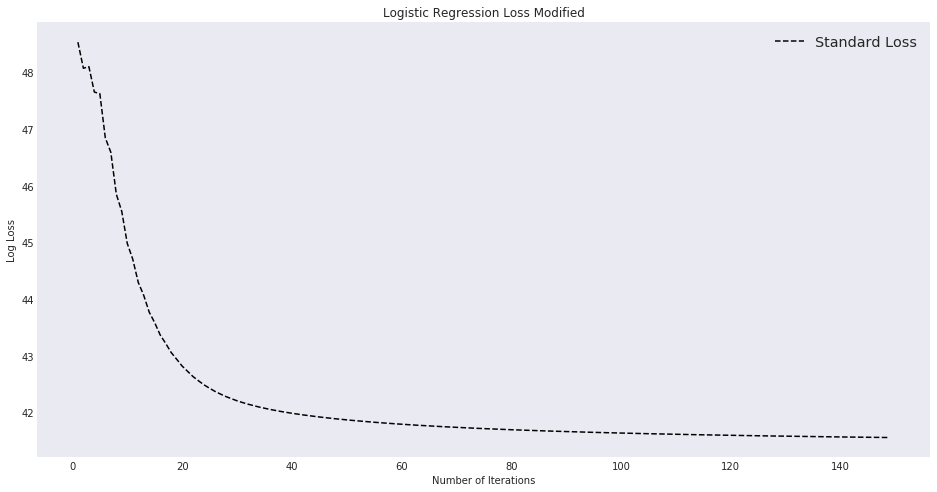

In [319]:
plotErrorCurves(LogLossToy, LogLossToy_Mod, title = 'Logistic Regression Loss Modified' )

In [293]:
LRLoss_Standard(scaledToyRDD, models[99])

52.01184975465333

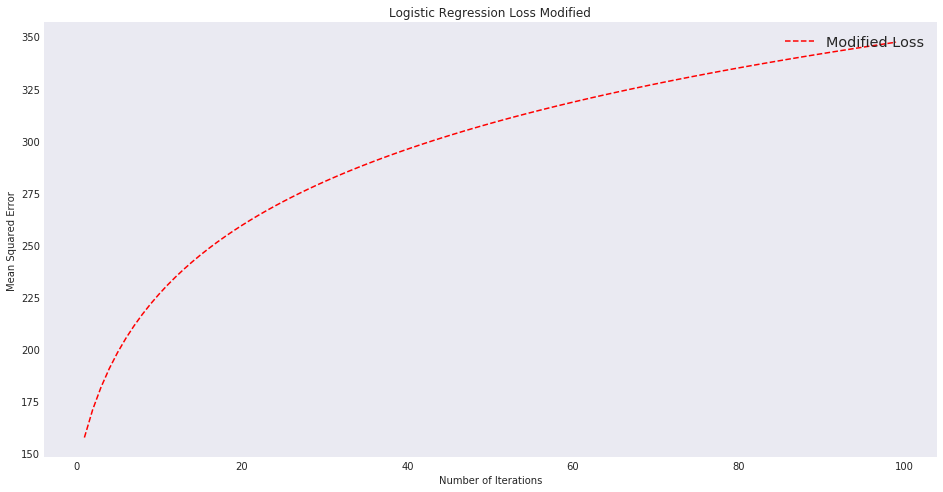

In [300]:
plotErrorCurves(LogLossToy, LogLossToy_Mod, title = 'Logistic Regression Loss Modified' )

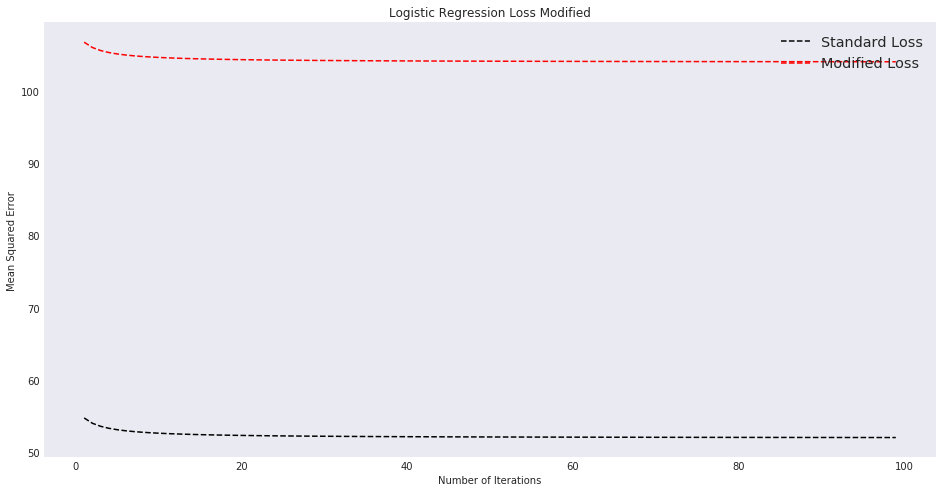

In [254]:
plotErrorCurves(LogLossToy, LogLossToy_Mod, title = 'Logistic Regression Loss Modified' )

In [320]:
models[149]

array([-2.25508078, -0.14161326, -0.91567531, -0.50779671, -0.24482655,
       -2.51212134,  0.17727569, -1.2172626 ,  0.14439694, -0.87176552,
        0.5916407 ,  1.20129834, -2.84275989,  0.36608786])

In [256]:
models_mod[99]

array([ 4.69010892, -0.59402971, -0.81017231, -0.79547439,  0.00650319,
       -0.93216729, -0.11522305, -0.37540178, -0.05776751, -0.78764846,
        0.45502624,  0.40446967, -0.96276212,  0.25379272])

# TESTING MLLIB

In [321]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint

# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(' ')]
    return LabeledPoint(values[0], values[1:])

toyData = scaledToyDF.rdd.map(lambda x: LabeledPoint(x[0], MLLibVectors.dense(x[1].toArray())))

data = sc.textFile("sample_svm_data.txt")
parsedData = data.map(parsePoint)

# Build the model
modeltest = LogisticRegressionWithLBFGS.train(toyData)

def predictionLabel(x, model):
    prob = 1/(1+math.exp(-np.dot(model, x)))
    if prob > 0.5:
        return [1, prob]
    else:
        return [-1, prob]
    
augmentedData = scaledToyRDD.map(lambda x: (x[0], np.append([1.0], x[1]))).cache()

labelsAndPredsMLLib = toyData.map(lambda p: (p.label, modeltest.predict(p.features)))
labelsAndPredsGD = augmentedData.map(lambda x: (x[0], predictionLabel(x[1], models[99])))

MLLibtrainErr = labelsAndPredsMLLib.filter(lambda lp: lp[0] != lp[1]).count() / float(toyData.count())

GDtrainErr = labelsAndPredsGD.filter(lambda lp: lp[0] != lp[1][0]).count() / float(augmentedData.count())
print("MLLib Training Error = " + str(MLLibtrainErr))
print("Gradient Descent Training Error = " + str(GDtrainErr))

MLLib Training Error = 0.38
Gradient Descent Training Error = 0.17


In [205]:
labelsAndPredsMLLib.collect()

[(0.0, 1),
 (0.0, 0),
 (1.0, 1),
 (1.0, 1),
 (1.0, 1),
 (0.0, 1),
 (0.0, 1),
 (0.0, 0),
 (1.0, 0),
 (0.0, 1),
 (0.0, 0),
 (0.0, 0),
 (0.0, 0),
 (0.0, 1),
 (1.0, 1),
 (0.0, 0),
 (0.0, 1),
 (0.0, 0),
 (0.0, 1),
 (0.0, 0),
 (0.0, 0),
 (0.0, 1),
 (1.0, 1),
 (1.0, 1),
 (0.0, 0),
 (0.0, 0),
 (0.0, 0),
 (0.0, 1),
 (0.0, 1),
 (0.0, 0),
 (1.0, 1),
 (0.0, 1),
 (0.0, 1),
 (0.0, 1),
 (0.0, 0),
 (0.0, 0),
 (1.0, 1),
 (1.0, 1),
 (0.0, 1),
 (0.0, 1),
 (1.0, 0),
 (0.0, 0),
 (0.0, 1),
 (0.0, 0),
 (0.0, 1),
 (0.0, 1),
 (1.0, 1),
 (0.0, 0),
 (1.0, 0),
 (0.0, 0),
 (0.0, 1),
 (0.0, 1),
 (0.0, 0),
 (1.0, 1),
 (1.0, 1),
 (1.0, 1),
 (0.0, 1),
 (0.0, 0),
 (0.0, 0),
 (1.0, 1),
 (1.0, 1),
 (0.0, 0),
 (0.0, 0),
 (1.0, 1),
 (0.0, 1),
 (1.0, 0),
 (0.0, 1),
 (0.0, 0),
 (0.0, 0),
 (0.0, 1),
 (0.0, 1),
 (0.0, 0),
 (0.0, 0),
 (1.0, 1),
 (0.0, 1),
 (0.0, 0),
 (0.0, 1),
 (1.0, 1),
 (0.0, 0),
 (0.0, 0),
 (0.0, 0),
 (1.0, 1),
 (0.0, 1),
 (0.0, 0),
 (0.0, 1),
 (0.0, 0),
 (1.0, 0),
 (0.0, 1),
 (0.0, 0),
 (0.0, 0),
 (0.0, 0),

In [317]:
labelsAndPredsGD.collect()

[(-1.0, [-1, 0.03766711515495237]),
 (-1.0, [-1, 0.12381294989999747]),
 (1.0, [1, 0.676641691519491]),
 (1.0, [-1, 0.3801417463179315]),
 (1.0, [-1, 0.0016234868529925884]),
 (-1.0, [-1, 0.0011693856100544458]),
 (-1.0, [-1, 0.016614557860088676]),
 (-1.0, [-1, 0.18517023530803453]),
 (1.0, [-1, 0.29575572361128927]),
 (-1.0, [1, 0.9530087259877738]),
 (-1.0, [-1, 1.2248239374442178e-06]),
 (-1.0, [-1, 1.8327199422583087e-07]),
 (-1.0, [-1, 0.004410098646685087]),
 (-1.0, [1, 0.6409965206976946]),
 (1.0, [1, 0.9503507879707521]),
 (-1.0, [-1, 2.5504867759106143e-05]),
 (-1.0, [1, 0.6145631307763129]),
 (-1.0, [-1, 0.01305353261290533]),
 (-1.0, [-1, 0.0089609189743191]),
 (-1.0, [-1, 0.046365091979560465]),
 (-1.0, [-1, 0.33583811010847536]),
 (-1.0, [-1, 0.49170079605477524]),
 (1.0, [1, 0.9702158589882948]),
 (1.0, [1, 0.7194658472924693]),
 (-1.0, [-1, 0.10645047993612813]),
 (-1.0, [-1, 1.5791272860431303e-15]),
 (-1.0, [-1, 0.20382115429327452]),
 (-1.0, [-1, 0.011954993357531711

In [251]:
unscaled = imputedToyDF.rdd.map(lambda x: (x[0], Vectors.dense(x[1:]))).toDF(['label', 'features'])

In [322]:
#test MLLib Logistic Regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=150, regParam=0, elasticNetParam=1)
lrModel = lr.fit(scaledToyDF)
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [-0.00559714314200757,-0.9592173866111241,-0.507017161414367,-0.23574585103151433,-4.196084377928534,0.21818790026078716,-1.3096033690182187,0.11420849152375381,-0.8488370911672432,0.5724655338688336,1.2403306475972142,-2.8320295060769443,0.3528221459517509]
Intercept: -2.574777393550733


In [323]:
mllibmodel = np.append(np.array(lrModel.intercept),np.array(lrModel.coefficients))
mllibmodel

array([-2.57477739, -0.00559714, -0.95921739, -0.50701716, -0.23574585,
       -4.19608438,  0.2181879 , -1.30960337,  0.11420849, -0.84883709,
        0.57246553,  1.24033065, -2.83202951,  0.35282215])

In [324]:
labelsAndPredsMLLib2 = augmentedData.map(lambda x: (x[0], predictionLabel(x[1], mllibmodel)))
MLLibtrainErr2 = labelsAndPredsMLLib2.filter(lambda lp: lp[0] != lp[1][0]).count() / float(augmentedData.count())
print(MLLibtrainErr2)

0.17


In [325]:
LRLoss_Standard(scaledToyRDD, mllibmodel)

41.44855461619726

In [326]:
LogLossToy[149]

41.560522567984684

In [327]:
labelsAndPredsMLLib2.collect()

[(-1.0, [-1, 0.15159677280247083]),
 (-1.0, [-1, 0.09488022401982503]),
 (1.0, [-1, 0.26107058818711043]),
 (1.0, [-1, 0.27508358334628996]),
 (1.0, [-1, 0.3803522188012307]),
 (-1.0, [-1, 0.3136935734462352]),
 (-1.0, [-1, 0.31880906976014184]),
 (-1.0, [-1, 0.024133879957250866]),
 (1.0, [-1, 0.1283456053101237]),
 (-1.0, [1, 0.5301673027666687]),
 (-1.0, [-1, 1.9398553423622847e-07]),
 (-1.0, [-1, 0.010480564197169905]),
 (-1.0, [-1, 0.08905285156217714]),
 (-1.0, [-1, 0.19327301292330934]),
 (1.0, [-1, 0.4766688862315384]),
 (-1.0, [-1, 0.001885906279529433]),
 (-1.0, [-1, 0.1955794147267796]),
 (-1.0, [-1, 0.03370613933284403]),
 (-1.0, [-1, 0.1535075288843467]),
 (-1.0, [-1, 0.04440201713401596]),
 (-1.0, [-1, 0.08329396249832828]),
 (-1.0, [-1, 0.3333468243875926]),
 (1.0, [1, 0.705556717355627]),
 (1.0, [1, 0.8735342190990348]),
 (-1.0, [-1, 0.21177082213498877]),
 (-1.0, [-1, 1.9379130903699473e-17]),
 (-1.0, [-1, 0.058604066097039366]),
 (-1.0, [1, 0.6120078299932661]),
 (-1.

In [289]:
math.log(math.exp(10))

10.0